In [1]:
import pandas as pd
import dgl
import torch
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
# from win10toast import ToastNotifier
# toast = ToastNotifier()
# toast.show_toast("Done")

# Data

In [3]:
data_dir = './big_network'

In [4]:
nodes = pd.read_csv(f'{data_dir}/data/nodes.csv', index_col=0)
nodes.set_index('bank', inplace=True)
nodes.head()

,assets,liabilities,buffer,weights,original_stress,additional_stress,original_losses,additional_losses,additional_defaults
bank,,,,,,,,,
b1,13.572286,0.161967,6.068679,24.253806,0.000433,0.000548,6.068679,0.171663,0
b10,1.159245,228.316327,226.497349,457.309267,0.008173,0.023458,226.497349,287.339651,6
b100,0.552285,0.887618,7.711700,11.883878,0.000212,0.000302,7.711700,1.884005,0
b1000,1.742721,0.992048,3.935538,9.898941,0.000177,0.001009,3.935538,1.307682,0
b1001,1.061990,0.314377,2.727904,5.239656,0.000094,0.002205,2.727904,0.700947,0


In [5]:
nodes.columns

Index(['assets', 'liabilities', 'buffer', 'weights', 'original_stress',
       'additional_stress', 'original_losses', 'additional_losses',
       'additional_defaults'],
      dtype='object')

In [6]:
node_attr = [
    'assets',
    'liabilities',
    'buffer',
    'weights',
]
nodes_features = nodes[node_attr]
nodes_features.head()

,assets,liabilities,buffer,weights
bank,,,,
b1,13.572286,0.161967,6.068679,24.253806
b10,1.159245,228.316327,226.497349,457.309267
b100,0.552285,0.887618,7.711700,11.883878
b1000,1.742721,0.992048,3.935538,9.898941
b1001,1.061990,0.314377,2.727904,5.239656


In [7]:
network = pd.read_csv(f'{data_dir}/data/network.csv', index_col=0)
network.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,b1491,b1492,b1493,b1494,b1495,b1496,b1497,b1498,b1499,b1500
b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plots

In [8]:
def plot_hist(s, name):
    plt.figure(figsize=(8, 6), dpi=100)
    sns.distplot(s)
    plt.title(name, fontsize=18)
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)

### Liabilities

c:\Users\vibal\PycharmProjects\systemic-risk-predictor\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


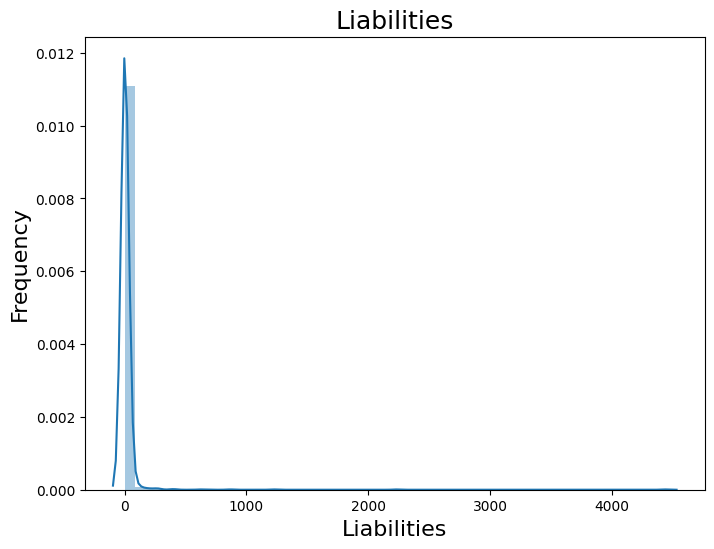

In [9]:
plot_hist(nodes['liabilities'], 'Liabilities')

### Liabilities < 1

c:\Users\vibal\PycharmProjects\systemic-risk-predictor\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


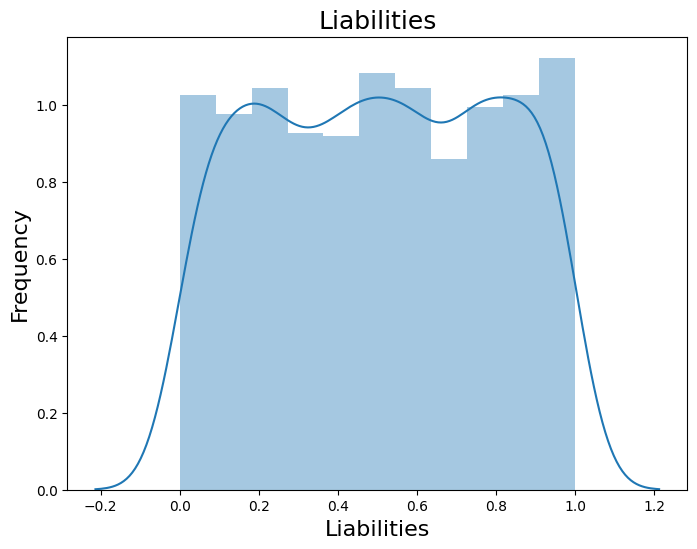

In [10]:
plot_hist(nodes['liabilities'][nodes['liabilities'] < 1], 'Liabilities')

### Weights

c:\Users\vibal\PycharmProjects\systemic-risk-predictor\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


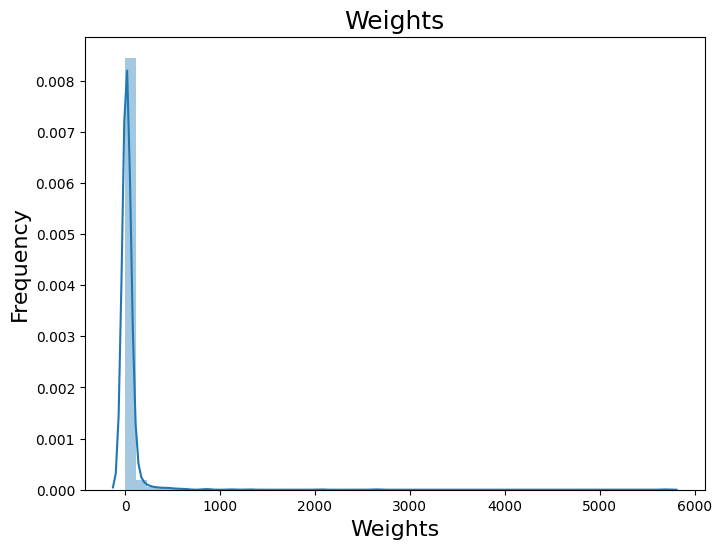

In [11]:
plot_hist(nodes['weights'], 'Weights')

### Correlations

In [12]:
corr = nodes.corr()
corr

,assets,liabilities,buffer,weights,original_stress,additional_stress,original_losses,additional_losses,additional_defaults
assets,1.000000,0.023470,0.077237,0.300888,0.300888,0.030136,0.077237,0.021029,0.020826
liabilities,0.023470,1.000000,0.868729,0.953010,0.953010,0.893452,0.868729,0.997770,0.988240
buffer,0.077237,0.868729,1.000000,0.902008,0.902008,0.820843,1.000000,0.858551,0.855299
weights,0.300888,0.953010,0.902008,1.000000,1.000000,0.864814,0.902008,0.948315,0.940514
original_stress,0.300888,0.953010,0.902008,1.000000,1.000000,0.864814,0.902008,0.948315,0.940514
additional_stress,0.030136,0.893452,0.820843,0.864814,0.864814,1.000000,0.820843,0.903068,0.921188
original_losses,0.077237,0.868729,1.000000,0.902008,0.902008,0.820843,1.000000,0.858551,0.855299
additional_losses,0.021029,0.997770,0.858551,0.948315,0.948315,0.903068,0.858551,1.000000,0.993809
additional_defaults,0.020826,0.988240,0.855299,0.940514,0.940514,0.921188,0.855299,0.993809,1.000000


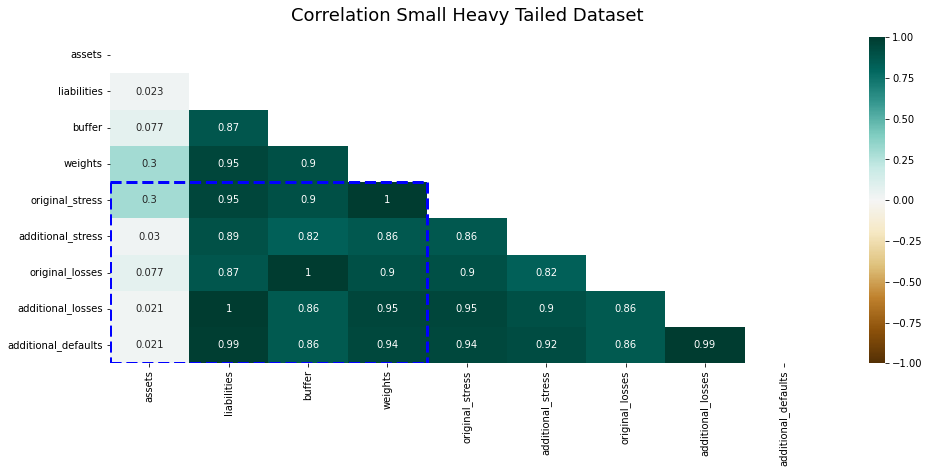

In [13]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Small Heavy Tailed Dataset', fontdict={'fontsize':18}, pad=16)
# add box lines
lines_style = dict(
    linestyles='dashed', 
    colors='blue', 
    linewidth=3,
)
heatmap.hlines([4, corr.shape[0]], xmin=0, xmax=4, **lines_style)
heatmap.vlines([0, 4], ymin=4, ymax=corr.shape[0], **lines_style)

## Get target

In [14]:
0.1*4

0.4

In [15]:
TARGET_COLUMN = 'additional_stress'
QUANTILES = [0.75, 0.5, 0.25]

quant = nodes[TARGET_COLUMN].quantile(QUANTILES)
quant

0.75    0.002706
0.50    0.000859
0.25    0.000218
Name: additional_stress, dtype: float64

In [16]:
is_quant = pd.DataFrame()
free = np.ones(nodes.shape[0]).astype(bool)
for k,v in quant.iteritems():
    is_quant[k] = np.logical_and(nodes[TARGET_COLUMN] >= v, free)
    free = np.logical_and(free, np.logical_not(is_quant[k]))
is_quant[0.0] = free

is_quant

,0.75,0.50,0.25,0.00
bank,,,,
b1,False,False,True,False
b10,True,False,False,False
b100,False,False,True,False
b1000,False,True,False,False
b1001,False,True,False,False
...,...,...,...,...
b995,False,False,True,False
b996,False,False,True,False
b997,True,False,False,False


In [17]:
print(f"Length {is_quant.shape[0]}")
print(f"Number of True values {is_quant.sum().sum()}")

Length 1500
Number of True values 1500


In [18]:
is_quant_np = is_quant.to_numpy().astype(float)
is_quant_np.dtype

dtype('float64')

In [19]:
target_np = is_quant_np.argmax(1)
target_np

array([2, 0, 2, ..., 0, 2, 3], dtype=int64)

In [20]:
is_quant = pd.DataFrame(data=target_np, index=is_quant.index, columns=['label'])
is_quant

,label
bank,
b1,2
b10,0
b100,2
b1000,1
b1001,1
...,...
b995,2
b996,2
b997,0


# Get Percentiles

0 is the highest class, n_classes - 1 the lowest

In [21]:
3 - pd.qcut(nodes[TARGET_COLUMN], 4, labels=False)

bank
b1       2
b10      0
b100     2
b1000    1
b1001    1
        ..
b995     2
b996     2
b997     0
b998     2
b999     3
Name: additional_stress, Length: 1500, dtype: int64

Percentile 100 is the highest, 0 the lowest

In [27]:
(pd.qcut(nodes[TARGET_COLUMN], 100, labels=False) / 100)

bank
b1       0.40
b10      0.98
b100     0.30
b1000    0.52
b1001    0.71
         ... 
b995     0.34
b996     0.27
b997     0.78
b998     0.32
b999     0.17
Name: additional_stress, Length: 1500, dtype: float64

# Labels - Percentiles

In [20]:
target_np[:10]

array([2, 0, 2, 1, 1, 3, 1, 0, 0, 1], dtype=int64)

In [57]:
# NOT USED

n = 4

alpha = 1   # alpha > 1 -> classes overlap; alpha = 1 -> classes touch; alpha < 1 -> classes more far apart; None -> middle point
if alpha is None:
    perc_unif = np.zeros(*target_np.shape)
else:
    perc_unif = (np.random.rand(*target_np.shape) - 0.5) / (n * alpha)    # [0,1) -.5 -> [-.5,.5) * 1/n -> [-1/n/2, 1/n/2]

perc_mid = perc = (target_np / n) + 1/n/2
perc = np.clip(0, perc_mid + perc_unif, 1)
perc[:10]

array([0.5621864 , 0.16416985, 0.65925436, 0.36126483, 0.33596248,
       0.87455077, 0.27031008, 0.03483931, 0.07166031, 0.31324281])

In [138]:
x = torch.as_tensor(perc)
# x = torch.as_tensor([0,0.75,0.5,0.25,1])

x_sc = x * (n - 1)
x_sc

tensor([1.6866, 0.4925, 1.9778,  ..., 0.2565, 2.0122, 2.9162],
       dtype=torch.float64)

In [136]:
x_sc = x_sc.reshape(-1)[:,None].repeat(1,n)
x_sc

tensor([[1.6866, 1.6866, 1.6866, 1.6866],
        [1.6866, 1.6866, 1.6866, 1.6866],
        [1.6866, 1.6866, 1.6866, 1.6866],
        ...,
        [2.9162, 2.9162, 2.9162, 2.9162],
        [2.9162, 2.9162, 2.9162, 2.9162],
        [2.9162, 2.9162, 2.9162, 2.9162]], dtype=torch.float64)

In [114]:
tmp = (torch.arange(0, n-1, (n-1)/n, dtype=torch.float))[None]
tmp

tensor([[0.0000, 0.7500, 1.5000, 2.2500]])

In [115]:
t = (x_sc - tmp)
t

tensor([[ 1.6866,  0.9366,  0.1866, -0.5634],
        [ 0.4925, -0.2575, -1.0075, -1.7575],
        [ 1.9778,  1.2278,  0.4778, -0.2722],
        ...,
        [ 0.2565, -0.4935, -1.2435, -1.9935],
        [ 2.0122,  1.2622,  0.5122, -0.2378],
        [ 2.9162,  2.1662,  1.4162,  0.6662]], dtype=torch.float64)

In [123]:
e = torch.logical_and(t < (n-1)/n, t >= 0).int()
lab = e.argmax(1)
lab[e.sum(1) == 0] = n-1
lab[:10]

tensor([2, 0, 2, 1, 1, 3, 1, 0, 0, 1])

In [117]:
# lab = np.clip(0, (perc * n - 1e-6).astype(int), n-1).astype(float)
# lab[:10]

In [128]:
np.logical_not(lab.numpy() == target_np).sum()

0

## Dataset

In [58]:
graph = nx.convert_matrix.from_pandas_adjacency(network, create_using=nx.DiGraph)
graph.edges[('b1', 'b55')]

{'weight': 0.37490927455228}

In order to group the features together we need to get a dictionary of {"bank":{"feat":values}}

In [64]:
{k:{"feat":torch.as_tensor(v, dtype=torch.float)} for k,v in nodes_features.T.to_dict('list').items()}['b10']

{'feat': tensor([22.2623,  0.9958,  2.5481, 26.9459])}

In [65]:
nx.set_node_attributes(graph, {k:{"feat":torch.as_tensor(v, dtype=torch.float)} for k,v in nodes_features.T.to_dict('list').items()})
graph.nodes(True)['b10']

{'feat': tensor([22.2623,  0.9958,  2.5481, 26.9459])}

Add target to graph

In [77]:
is_quant.to_dict('index')['b10']

{'label': 3}

In [67]:
nx.set_node_attributes(graph, is_quant.to_dict('index'))
graph.nodes(True)['b10']

{'feat': tensor([22.2623,  0.9958,  2.5481, 26.9459]), 'label': 3}

Add bank id to graph

In [86]:
{k:{'id':int(k[1:])} for k in is_quant.index}['b116']

{'id': 116}

In [87]:
nx.set_node_attributes(graph, {k:{'id':int(k[1:])} for k in is_quant.index})
graph.nodes(True)['b10']

{'feat': tensor([22.2623,  0.9958,  2.5481, 26.9459]), 'label': 3, 'id': 10}

### Create dgl graph

In [68]:
print(f"Graph with {graph.number_of_nodes()} nodes")
print(f"Graph with {graph.number_of_edges()} edges")

Graph with 125 nodes
Graph with 249 edges


In [69]:
graph_dgl = dgl.from_networkx(graph,node_attrs=['feat', 'label'],edge_attrs=['weight'])
graph_dgl

Graph(num_nodes=125, num_edges=249,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

### Dataset class

https://docs.dgl.ai/en/0.6.x/api/python/dgl.data.html

The basic DGL dataset for creating graph datasets. This class defines a basic template class for DGL Dataset. The following steps will are executed automatically:

1. Check whether there is a dataset cache on disk (already processed and stored on the disk) by invoking has_cache(). If true, goto 5.
2. Call download() to download the data.
3. Call process() to process the data.
4. Call save() to save the processed dataset on disk and goto 6.
5. Call load() to load the processed dataset from disk.
6. Done.

In [70]:
class ContagionDataset(dgl.data.DGLDataset):
    def __init__(self, sets_lengths=(0.8,0.1,0.1)):
        super().__init__(name='sistemic_risk', verbose=True)
        self.sets_lengths = sets_lengths

    def process(self):
        # graph with nodes and edges features
        self.graph = graph_dgl

        # for each graph in list: in this case only one
        # create train, validation and test masks
        n_nodes = self.graph.num_nodes()
        n_train, n_val = (int(n_nodes * k) for k in self.sets_lengths[:2])
        train_mask, val_mask, test_mask = [torch.zeros(n_nodes, dtype=torch.bool) for k in range(3)]
        train_mask[:n_train] = True
        val_mask[n_train:n_train+n_val] = True
        test_mask[n_train+n_val:] = True

        # shuffle
        idx = torch.randperm(n_nodes)
        train_mask, val_mask[idx], test_mask[idx] = train_mask[idx], val_mask[idx], test_mask[idx]

        # set mask in nodes
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self,i):
        return self.graphs[i]
    

### Try DropEdge

In [71]:
import copy
np.random.seed(123)

In [72]:
k = copy.deepcopy(graph_dgl)
k

Graph(num_nodes=125, num_edges=249,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

In [73]:
remove_eids = np.random.randint(k.num_edges(), size=20)
remove_eids

array([109, 126,  66, 220,  98, 230,  17,  83, 106, 123,  57, 214, 225,
        96, 113, 126,  47,  73,  32, 174])

In [74]:
k.remove_edges(remove_eids)
k

Graph(num_nodes=125, num_edges=230,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

In [75]:
graph_dgl

Graph(num_nodes=125, num_edges=249,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})